# GLM: Robust Regression using Custom Likelihood for Outlier Classification

`GLM-robust-with-outlier-detection.ipynb`

Using PyMC3 for Robust Regression with Outlier Detection using the Hogg 2010 Signal vs Noise method. 

**Modelling concept:**
+ This model uses a custom likelihood function as a mixture of two likelihoods, one for the main data-generating function (a linear model that we care about), and one for outliers.
+ The model does not marginalize and thus gives us a classification of outlier-hood for each datapoint
+ The dataset is tiny and hardcoded into this Notebook. It contains errors in both the x and y, but we will deal here with only errors in y.

**Complementary approaches:**
+ This is a complementary approach to the Student-T robust regression as illustrated in Thomas Wiecki's notebook in the [PyMC3 documentation](https://docs.pymc.io/notebooks/GLM-robust.html), and that approach is also compared
+ See also a [gist by Dan FM](https://gist.github.com/dfm/5250dd2f17daf60cbe582ceeeb2fd12f) that he published after a quick twitter conversation - his "Hogg improved" model uses this same model structure and cleverly marginalizes over the outlier class but also observes it during sampling using a `pm.Deterministic` <- this is really nice
+ The likelihood evaluation is essentially a copy of eqn 17 in "Data analysis recipes: Fitting a model to data" - [Hogg 2010](http://arxiv.org/abs/1008.4686)
+ The model is adapted specifically from Jake Vanderplas' [implementation](http://www.astroml.org/book_figures/chapter8/fig_outlier_rejection.html)



## Contents

+ [Setup](#Setup)
    + [Installation Notes](#Installation-Notes)
    + [Imports](#Imports)
    + [Load Data](#Load-Data)
+ [1. Basic EDA](#1.-Basic-EDA)
+ [2. Basic Feature Engineering](#2.-Basic-Feature-Engineering)
+ [3. Simple Linear Model with no Outlier Correction](#3.-Simple-Linear-Model-with-no-Outlier-Correction)
+ [4. Simple Linear Model with Robust Student-T Likelihood](#4.-Simple-Linear-Model-with-Robust-Student-T-Likelihood)
+ [5. Linear Model with Custom Likelihood to Distinguish Outliers: Hogg Method](#5.-Linear-Model-with-Custom-Likelihood-to-Distinguish-Outliers:-Hogg-Method)

## Setup

### Installation Notes

See the project [README](https://github.com/jonsedar/pymc3_examples/blob/master/README.md) for full details. For MVP reproduction, see following notes

General

+ This is a Python 3.6 project using latest available [PyMC3](https://github.com/pymc-devs/pymc3) at time of writing `pymc3=3.8`
+ Updated in 2020Q2 using [ContinuumIO Anaconda](https://www.continuum.io/downloads) distribution on a MacBook Air 2020 1.2GHz i7 Quad Core, 16GB RAM, OSX 10.15.3
+ If runs become unstable or Theano throws weird errors, first try clearing the cache `theano-cache clear` and rerunning the notebook.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Imports

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from matplotlib.lines import Line2D
from scipy import stats

%load_ext watermark
%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

numpy     : 1.20.0
scipy     : 1.6.0
matplotlib: None
pandas    : 1.2.1
seaborn   : 0.11.1
pymc3     : 3.11.0
theano    : 1.1.2
arviz     : 0.11.0

Compiler    : Clang 11.0.1 
OS          : Darwin
Release     : 20.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Git hash: 58332cdea36869351a2d985ff95ad4d2e16c0e8f



In [3]:
sns.set(style="darkgrid", palette="muted", context="notebook")
plt.rcParams["figure.figsize"] = 16, 4
np.random.seed(0)

### Load Data

We'll use the Hogg 2010 data available at  https://github.com/astroML/astroML/blob/master/astroML/datasets/hogg2010test.py

It's a very small dataset so for convenience, it's hardcoded below

In [4]:
# cut & pasted directly from the fetch_hogg2010test() function
# identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(
    np.array(
        [
            [1, 201, 592, 61, 9, -0.84],
            [2, 244, 401, 25, 4, 0.31],
            [3, 47, 583, 38, 11, 0.64],
            [4, 287, 402, 15, 7, -0.27],
            [5, 203, 495, 21, 5, -0.33],
            [6, 58, 173, 15, 9, 0.67],
            [7, 210, 479, 27, 4, -0.02],
            [8, 202, 504, 14, 4, -0.05],
            [9, 198, 510, 30, 11, -0.84],
            [10, 158, 416, 16, 7, -0.69],
            [11, 165, 393, 14, 5, 0.30],
            [12, 201, 442, 25, 5, -0.46],
            [13, 157, 317, 52, 5, -0.03],
            [14, 131, 311, 16, 6, 0.50],
            [15, 166, 400, 34, 6, 0.73],
            [16, 160, 337, 31, 5, -0.52],
            [17, 186, 423, 42, 9, 0.90],
            [18, 125, 334, 26, 8, 0.40],
            [19, 218, 533, 16, 6, -0.78],
            [20, 146, 344, 22, 5, -0.56],
        ]
    ),
    columns=["id", "x", "y", "sigma_y", "sigma_x", "rho_xy"],
)

dfhogg["id"] = dfhogg["id"].apply(lambda x: "p{}".format(int(x)))
dfhogg.set_index("id", inplace=True)
dfhogg.head()

x      y  sigma_y  sigma_x  rho_xy
id                                        
p1  201.0  592.0     61.0      9.0   -0.84
p2  244.0  401.0     25.0      4.0    0.31
p3   47.0  583.0     38.0     11.0    0.64
p4  287.0  402.0     15.0      7.0   -0.27
p5  203.0  495.0     21.0      5.0   -0.33

---

## 1. Basic EDA

Exploratory Data Analysis

Note:
+ this is very rudimentary so we can quickly get to the `pymc3`
+ the dataset contains errors in both the x and y, but we will deal here with only errors in y.
+ see the [Hogg 2010 paper](https://arxiv.org/pdf/1008.4686.pdf) for more detail

<ipython-input-5-1283976e6cc8>:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  _ = gd.ax_joint.annotate(


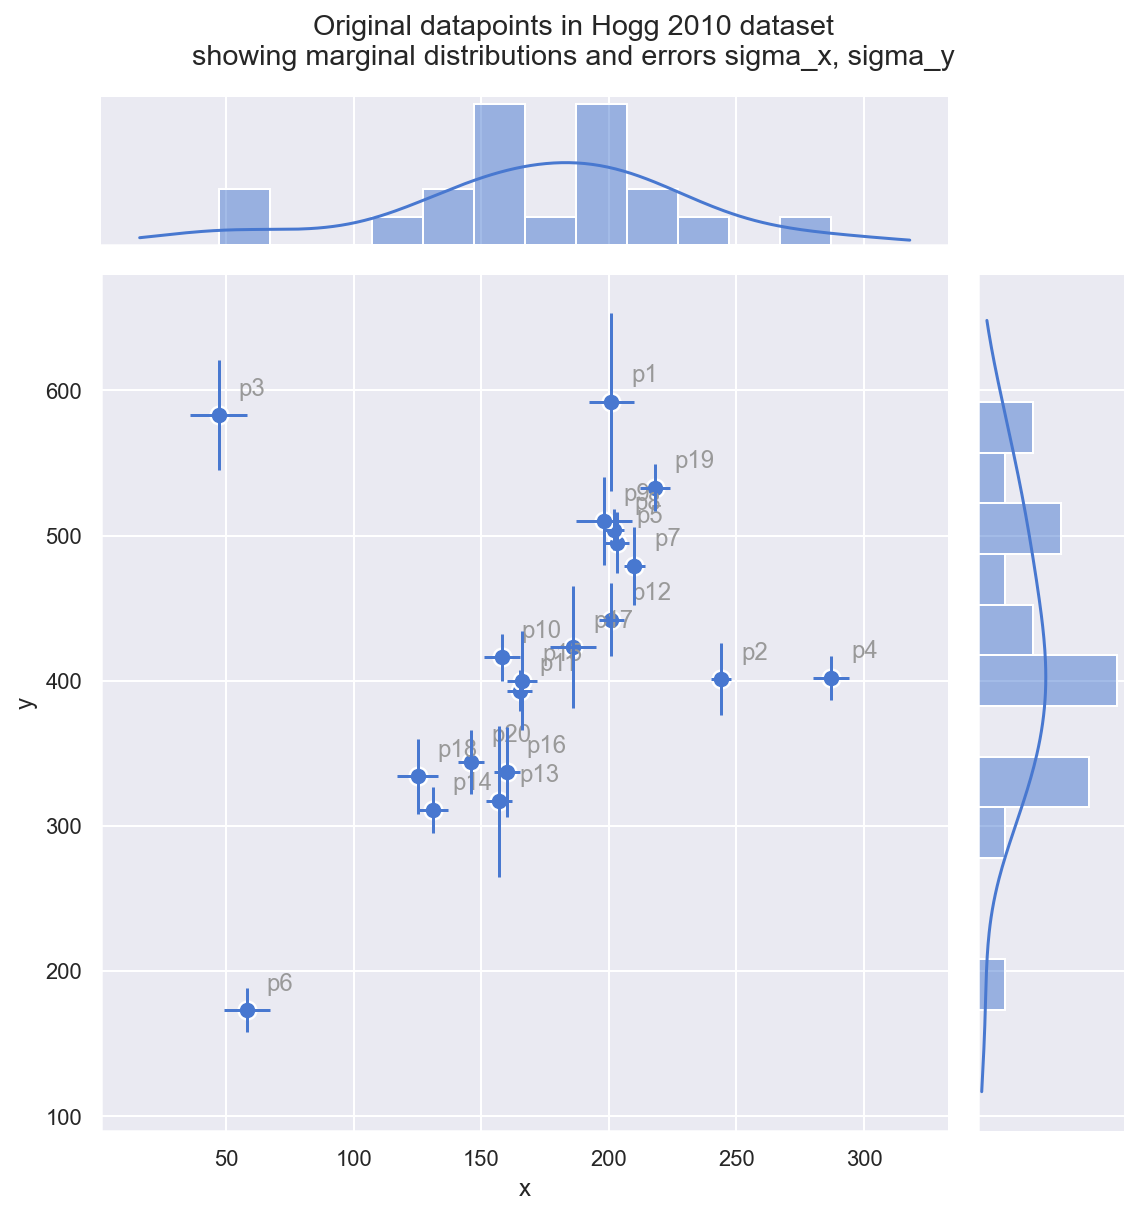

In [5]:
gd = sns.jointplot(
    x="x",
    y="y",
    data=dfhogg,
    kind="scatter",
    height=8,
    marginal_kws={"bins": 12, "kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"edgecolor": "w", "linewidth": 1.2, "s": 80},
)

_ = gd.ax_joint.errorbar(
    "x", "y", "sigma_y", "sigma_x", fmt="none", ecolor="#4878d0", data=dfhogg, zorder=10
)

for idx, r in dfhogg.iterrows():
    _ = gd.ax_joint.annotate(
        s=idx,
        xy=(r["x"], r["y"]),
        xycoords="data",
        xytext=(10, 10),
        textcoords="offset points",
        color="#999999",
        zorder=1,
    )


_ = gd.fig.suptitle(
    (
        "Original datapoints in Hogg 2010 dataset\n"
        + "showing marginal distributions and errors sigma_x, sigma_y"
    ),
    y=1.05,
)

**Observe**:  

+ Even judging just by eye, you can see these observations mostly fall on / around a straight line with positive gradient
+ It looks like a few of the datapoints may be outliers from such a line
+ Measurement error (independently on x and y) varies across the observations

---

## 2. Basic Feature Engineering

Note: ordinarily I might run through more formalised steps to split into Train and Test sets (to later help evaluate model fit), but here I'll just fit the model to the full dataset and stop at inference

### 2.1 Transform and standardize dataset

It's common practice to standardize the input values to a linear model, because this leads to coefficients 
sitting in the same range and being more directly comparable. e.g. Gelman notes this in a 2007 
paper: http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf.

So, following Gelman's paper above, we'll divide by 2 s.d. here

+ since this model is very simple, we just standardize directly, 
rather than using e.g. a `scikit-learn` `FunctionTransformer`
+ ignoring `rho_xy` for now

**Additional note** on scaling the output feature `y` and measurement error `sigma_y`:
+ This is unconventional - typically you wouldn't scale an output feature
+ However, in the Hogg model we fit a custom two-part likelihood function of Normals which encourages 
a globally minimised log-loss by allowing outliers to fit to their own Normal distribution. This 
outlier distribution is specified using a stdev stated as an offset `sigma_y_out` from `sigma_y`
+ This offset value has the effect of requiring `sigma_y` to be restated in the same scale as the stdev of `y`

Standardize (mean center and divide by 2 sd):

In [6]:
dfhoggs = (dfhogg[["x", "y"]] - dfhogg[["x", "y"]].mean(0)) / (2 * dfhogg[["x", "y"]].std(0))
dfhoggs["sigma_x"] = dfhogg["sigma_x"] / (2 * dfhogg["x"].std())
dfhoggs["sigma_y"] = dfhogg["sigma_y"] / (2 * dfhogg["y"].std())

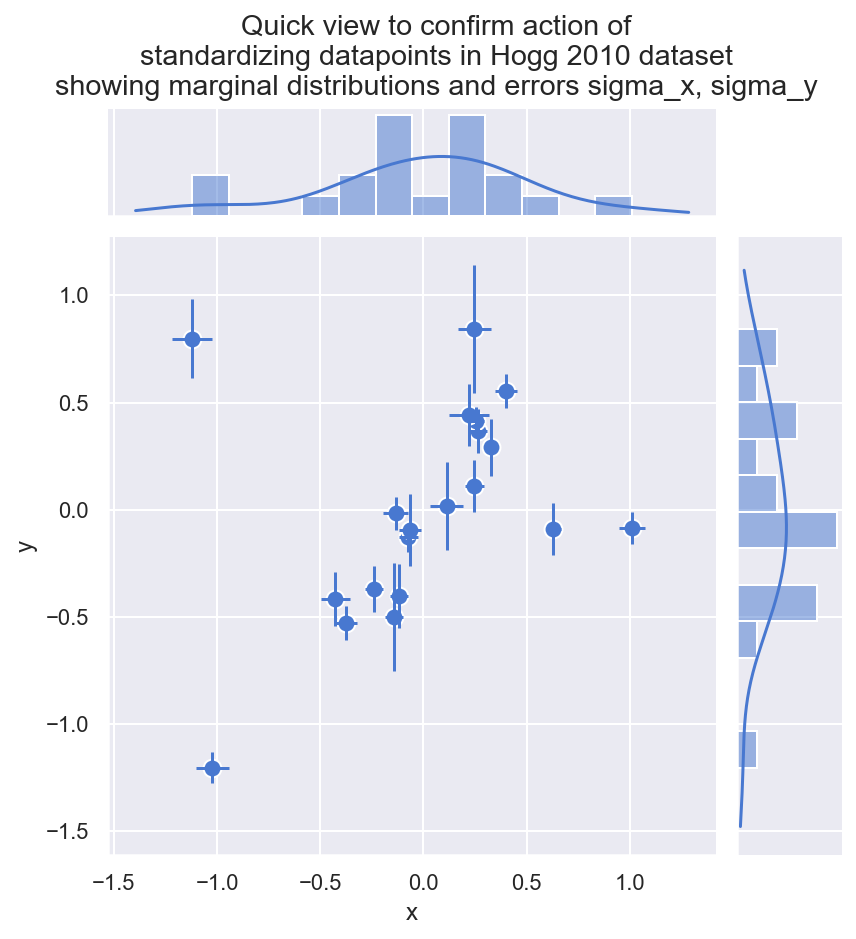

In [7]:
gd = sns.jointplot(
    x="x",
    y="y",
    data=dfhoggs,
    kind="scatter",
    height=6,
    marginal_kws={"bins": 12, "kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"edgecolor": "w", "linewidth": 1, "s": 80},
)
_ = gd.ax_joint.errorbar("x", "y", "sigma_y", "sigma_x", fmt="none", ecolor="#4878d0", data=dfhoggs)
_ = gd.fig.suptitle(
    (
        "Quick view to confirm action of\n"
        + "standardizing datapoints in Hogg 2010 dataset\n"
        + "showing marginal distributions and errors sigma_x, sigma_y"
    ),
    y=1.08,
)

---

## 3. Simple Linear Model with no Outlier Correction

### 3.1 Specify Model

Before we get more advanced, I want to demo the fit of a simple linear model with Normal likelihood function. The priors are also Normally distributed, so this behaves like an OLS with Ridge Regression (L2 norm).

Note: the dataset also has `sigma_x` and `rho_xy` available, but for this exercise, I've chosen to only use `sigma_y`

$$\hat{y} \sim \mathcal{N}(\beta^{T} \vec{x}_{i}, \sigma_{i})$$

where:  

+ $\beta$ = $\{1, \beta_{j \in X_{j}}\}$  <--- linear coefs in $X_{j}$, in this case `1 + x`
+ $\sigma$ = error term <--- in this case we set this to an _unpooled_ $\sigma_{i}$: the measured error `sigma_y` for each datapoint



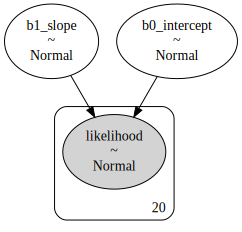

In [8]:
with pm.Model() as mdl_ols:

    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal("b0_intercept", mu=0, sigma=10)
    b1 = pm.Normal("b1_slope", mu=0, sigma=10)

    ## Define linear model
    y_est = b0 + b1 * dfhoggs["x"]

    ## Define Normal likelihood
    likelihood = pm.Normal("likelihood", mu=y_est, sigma=dfhoggs["sigma_y"], observed=dfhoggs["y"])

pm.model_to_graphviz(mdl_ols)

### 3.2 Fit Model

Note purposefully missing a step here for prior predictive checks...

#### 3.2.1 Sample Posterior

In [9]:
with mdl_ols:
    trc_ols = pm.sample(
        tune=5000,
        draws=500,
        chains=4,
        cores=4,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
    )

/Users/CloudChaoszero/Documents/Projects-Dev/pymc3/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 10500
Interrupted at 10,499 [20%]: Average Loss = 308.79
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1_slope, b0_intercept]


Sampling 4 chains for 5_000 tune and 500 draw iterations (20_000 + 2_000 draws total) took 34 seconds.


#### 3.2.2 View Diagnostics

NOTE: We will illustrate this OLS fit and compare to the datapoints in the final comparison plot

Traceplot

/Users/CloudChaoszero/opt/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


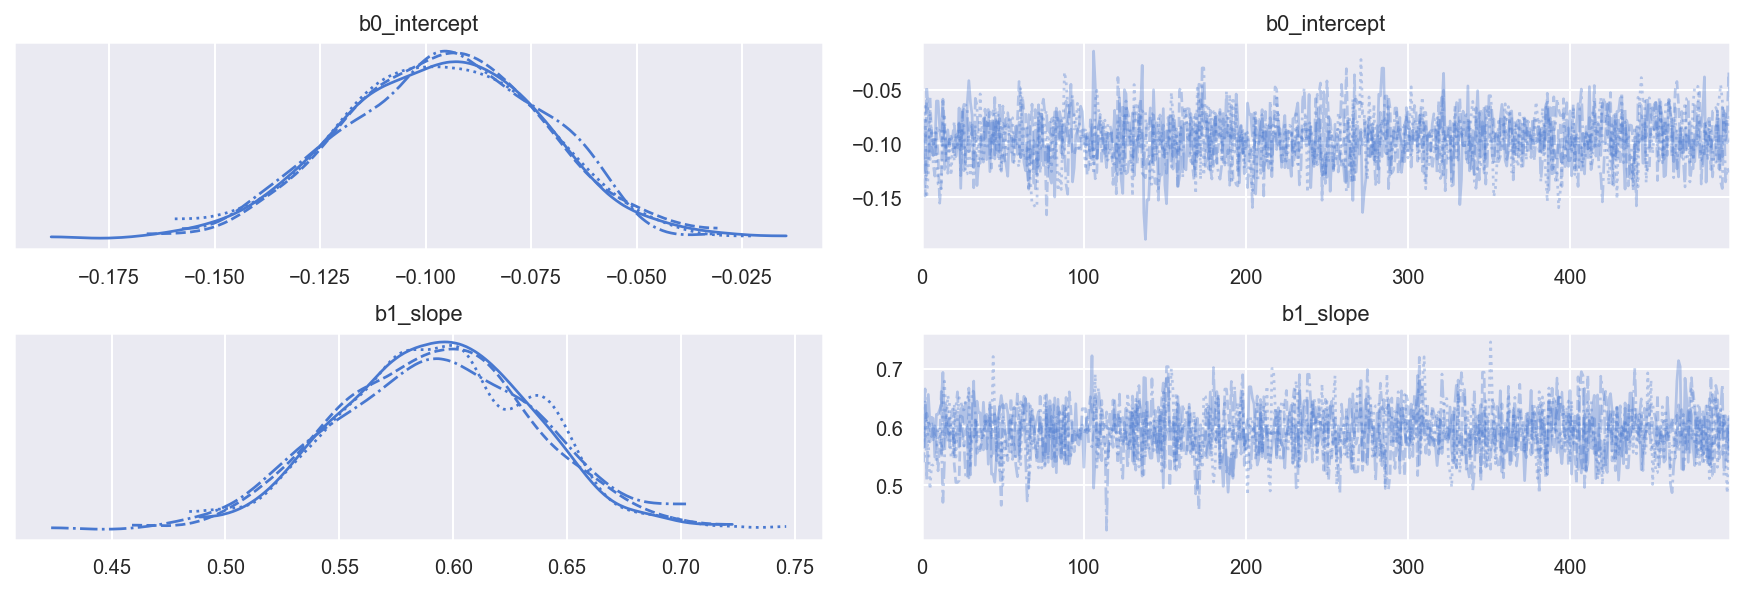

In [10]:
_ = az.plot_trace(trc_ols)

Plot posterior joint distribution (since the model has only 2 coeffs, we can easily view this as a 2D joint distribution)

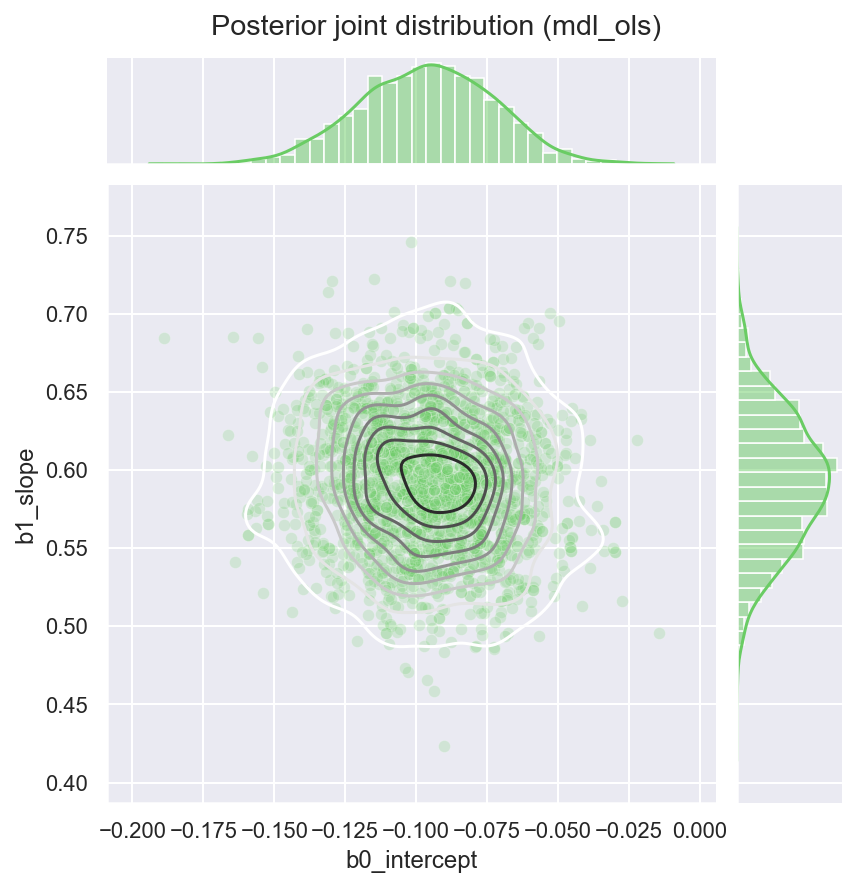

In [11]:
df_trc_ols = pm.trace_to_dataframe(trc_ols)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_ols,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
    color=sns.color_palette()[2],
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (mdl_ols)", y=1.02)

---

## 4. Simple Linear Model with Robust Student-T Likelihood

I've added this brief section in order to directly compare the Student-T based method exampled in Thomas Wiecki's notebook in the [PyMC3 documentation](http://pymc-devs.github.io/pymc3/GLM-robust/)

Instead of using a Normal distribution for the likelihood, we use a Student-T which has fatter tails. In theory this allows outliers to have a smaller influence in the likelihood estimation. This method does not produce inlier / outlier flags (it marginalizes over such a classification) but it's simpler and faster to run than the Signal Vs Noise model below, so a comparison seems worthwhile.


### 4.1 Specify Model

In this modification, we allow the likelihood to be more robust to outliers (have fatter tails)

$$\hat{y} \sim \text{StudentT}(\beta^{T} \vec{x}_{i}, \sigma_{i}, \nu)$$

where:  

+ $\beta$ = $\{1, \beta_{j \in X_{j}}\}$  <--- linear coefs in $X_{j}$, in this case `1 + x`
+ $\sigma$ = error term <--- in this case we set this to an _unpooled_ $\sigma_{i}$: the measured error `sigma_y` for each datapoint
+ $\nu$ = degrees of freedom <--- allowing a pdf with fat tails and thus less influence from outlier datapoints

Note: the dataset also has `sigma_x` and `rho_xy` available, but for this exercise, I've chosen to only use `sigma_y`

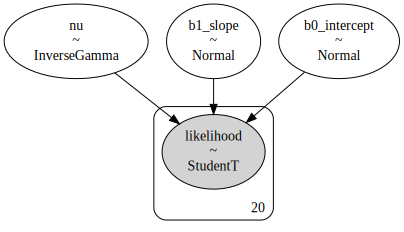

In [12]:
with pm.Model() as mdl_studentt:

    # define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal("b0_intercept", mu=0, sigma=10)
    b1 = pm.Normal("b1_slope", mu=0, sigma=10)

    # define linear model
    y_est = b0 + b1 * dfhoggs["x"]

    # define prior for StudentT degrees of freedom
    # InverseGamma has nice properties:
    # it's continuous and has support x ∈ (0, inf)
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # define Student T likelihood
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=dfhoggs["sigma_y"], nu=nu, observed=dfhoggs["y"]
    )

pm.model_to_graphviz(mdl_studentt)

### 4.2 Fit Model

#### 4.2.1 Sample Posterior

In [13]:
with mdl_studentt:
    trc_studentt = pm.sample(
        tune=5000,
        draws=500,
        chains=4,
        cores=4,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
    )

/Users/CloudChaoszero/Documents/Projects-Dev/pymc3/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 15700
Interrupted at 15,699 [31%]: Average Loss = 28.621
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, b1_slope, b0_intercept]


Sampling 4 chains for 5_000 tune and 500 draw iterations (20_000 + 2_000 draws total) took 28 seconds.


#### 4.2.2 View Diagnostics

NOTE: We will illustrate this StudentT fit and compare to the datapoints in the final comparison plot

Traceplot

/Users/CloudChaoszero/opt/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


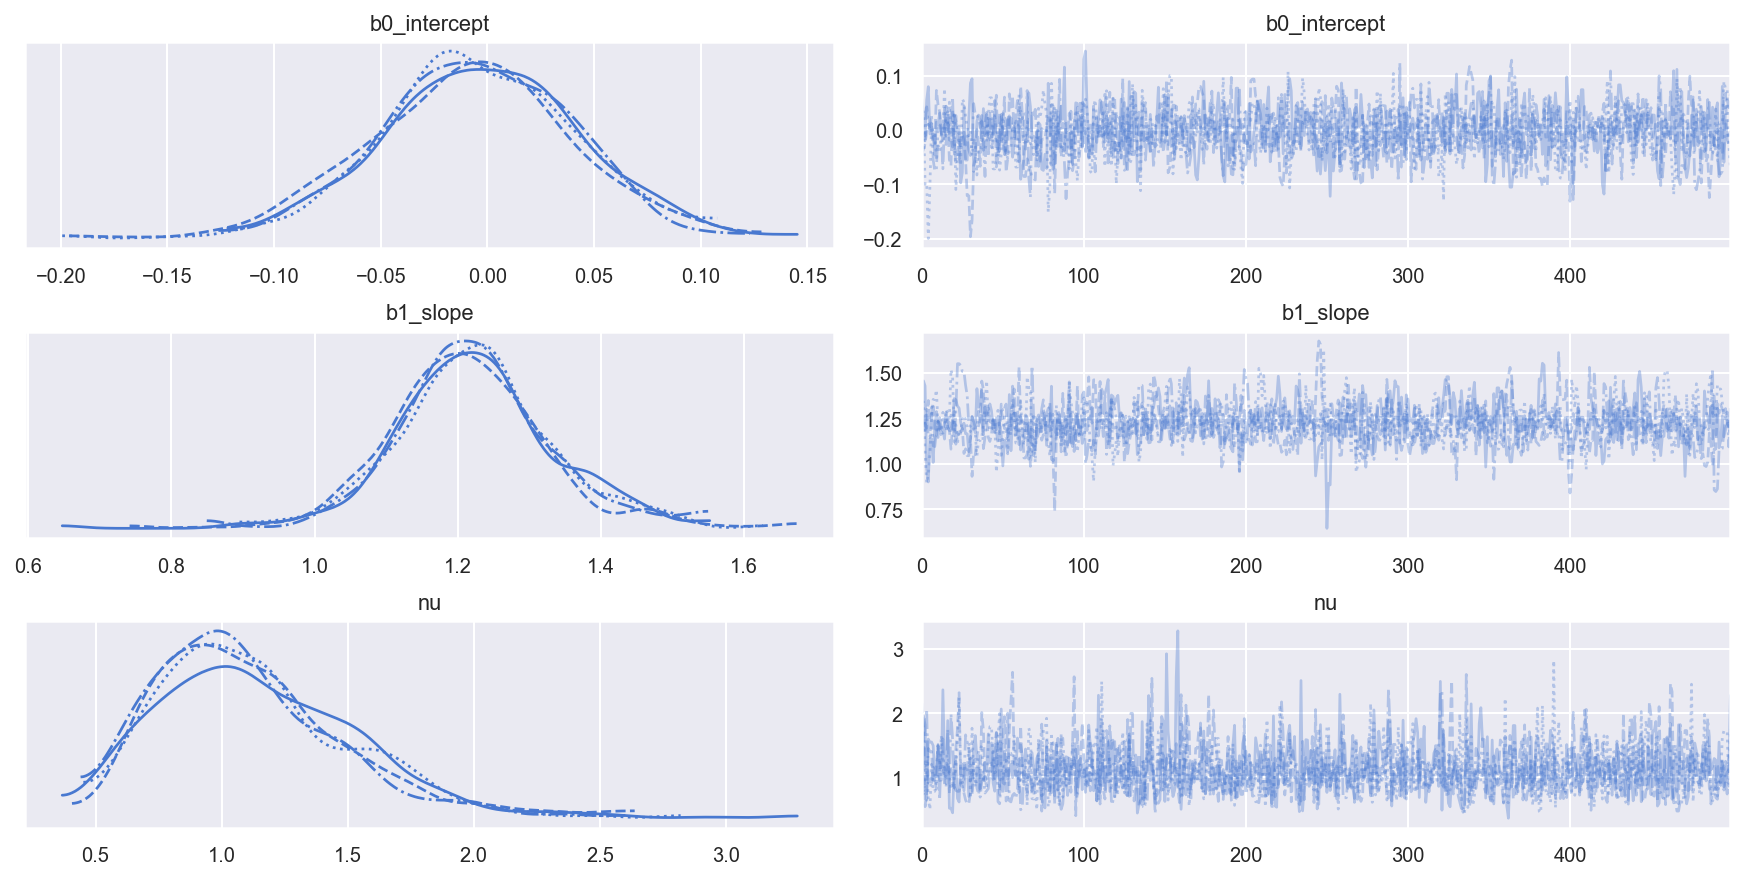

In [14]:
_ = az.plot_trace(trc_studentt)

PLot posterior joint distribution

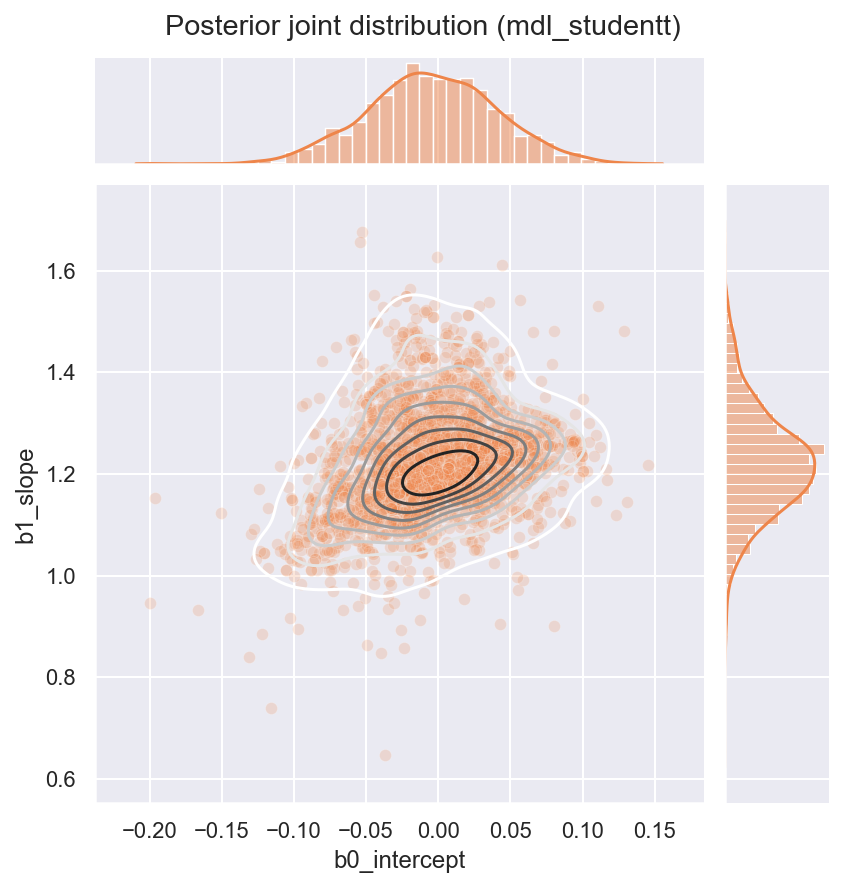

In [15]:
df_trc_studentt = pm.trace_to_dataframe(trc_studentt)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_studentt,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
    color=sns.color_palette()[1],
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (mdl_studentt)", y=1.02)

#### 4.2.3 View the shift in posterior joint distributions from OLS to StudentT

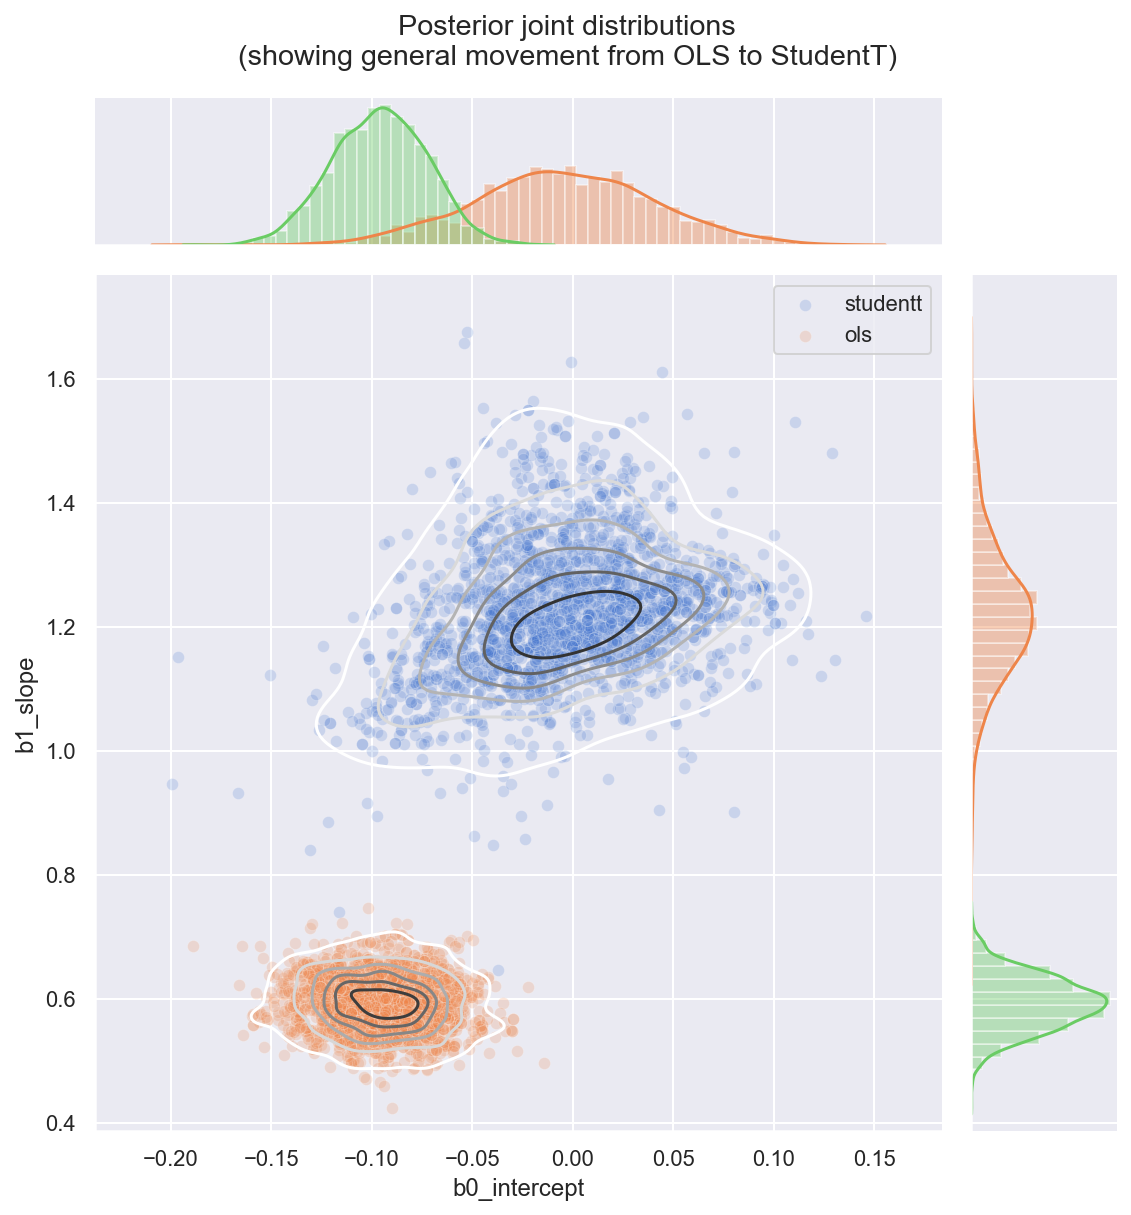

In [16]:
fts = ["b0_intercept", "b1_slope"]
df_trc = pd.concat((df_trc_ols[fts], df_trc_studentt[fts]), sort=False)
df_trc["model"] = pd.Categorical(
    np.repeat(["ols", "studentt"], len(df_trc_ols)),
    categories=["empty_force_cmap", "studentt", "ols"],
    ordered=True,
)

gd = sns.JointGrid(x="b0_intercept", y="b1_slope", data=df_trc, height=8)
_ = gd.fig.suptitle(
    ("Posterior joint distributions" + "\n(showing general movement from OLS to StudentT)"),
    y=1.05,
)

_, x_bin_edges = np.histogram(df_trc["b0_intercept"], 60)
_, y_bin_edges = np.histogram(df_trc["b1_slope"], 60)

kde_kws = dict(zorder=2, n_levels=7, cmap="gray_r")
dist_kws = dict(kde_kws=dict(cut=1), axlabel=False)

for idx, grp in df_trc.groupby("model"):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # cheap hack to ignore warnings from plot empty categorical grp

        _ = sns.scatterplot(
            grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, alpha=0.2, label=idx
        )
        _ = sns.kdeplot(grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, **kde_kws)
        _ = sns.distplot(grp["b0_intercept"], bins=x_bin_edges, ax=gd.ax_marg_x, **dist_kws)
        _ = sns.distplot(
            grp["b1_slope"], vertical=True, bins=y_bin_edges, ax=gd.ax_marg_y, **dist_kws
        )
_ = gd.ax_joint.legend()

**Observe:**

+ Both parameters `b0_intercept` and `b1_slope` appear to have greater variance
than in the OLS regression
+ This is due to $\nu$ appearing to converge to a value `nu ~ 1`, indicating 
that a fat-tailed likelihood has a better fit than a thin-tailed one
+ The parameter `b0_intercept` has moved much closer to $0$, which is 
interesting: if the theoretical relationship `y ~ f(x)` has no offset, 
then for this mean-centered dataset, the intercept should indeed be $0$: it 
might easily be getting pushed off-course by outliers in the OLS model.
+ The parameter `b1_slope` has accordingly become greater: perhaps moving 
closer to the theoretical function `f(x)`

---

## 5. Linear Model with Custom Likelihood to Distinguish Outliers: Hogg Method

Please read the paper (Hogg 2010) and Jake Vanderplas' code for more complete information about the modelling technique.

The general idea is to create a 'mixture' model whereby datapoints can be described by either:

1. the proposed (linear) model (thus a datapoint is an inlier), or
2. a second model, which for convenience we also propose to be linear, but allow it to have a different mean and variance (thus a datapoint is an outlier)


### 5.1 Specify Model

The likelihood is evaluated over a mixture of two likelihoods, one for 'inliers', one for 'outliers'. A Bernoulli distribution is used to randomly assign datapoints in N to either the inlier or outlier groups, and we sample the model as usual to infer robust model parameters and inlier / outlier flags:

$$
\mathcal{logL} = \sum_{i}^{i=N} log \left[ \frac{(1 - B_{i})}{\sqrt{2 \pi \sigma_{in}^{2}}} exp \left( - \frac{(x_{i} - \mu_{in})^{2}}{2\sigma_{in}^{2}} \right) \right] + \sum_{i}^{i=N} log \left[ \frac{B_{i}}{\sqrt{2 \pi (\sigma_{in}^{2} + \sigma_{out}^{2})}} exp \left( - \frac{(x_{i}- \mu_{out})^{2}}{2(\sigma_{in}^{2} + \sigma_{out}^{2})} \right) \right]
$$

where:  
+ $B_{i}$ is Bernoulli-distibuted $B_{i} \in \{0_{(inlier)},1_{(outlier)}\}$
+ $\mu_{in} = \beta^{T} \vec{x}_{i}$ as before for inliers, where $\beta$ = $\{1, \beta_{j \in X_{j}}\}$  <--- linear coefs in 
$X_{j}$, in this case `1 + x`
+ $\sigma_{in}$ = noise term <--- in this case we set this to an _unpooled_ $\sigma_{i}$: the measured error `sigma_y` for each datapoint
+ $\mu_{out}$ <--- is a random _pooled_ variable for outliers
+ $\sigma_{out}$ = additional noise term <--- is a random _unpooled_ variable for outliers


**Implementation note:**
    
A version of this Notebook was submitted and accepted into the [pymc3 docs](https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html) on 2015-12-21 with a log-likelihood specified directly in `theano`. In the time since, the `pm.DensityDist` class has been updated to require a custom `random` function to enable sampling, and on 2018-07-24, Thomas Wiecki kindly reimplemented this model specification accordingly, using the `Normal` and `Potential` classes from `pymc3`. 

This use of the `Potential` class combined with `logp` to create a likelihood is a new idea to me. It makes hand-wavy sense in [the docs](http://pymc-devs.github.io/pymc/modelbuilding.html#the-potential-class), and it seems to make it easier to build models where a feature is not observed e.g. the Bernoulli switching variable here.

I found a few more resources on this usage of `Potential` that are worth referring to:

+ [Junpenglao's presentation on likelihoods](https://github.com/junpenglao/All-that-likelihood-with-PyMC3) at PyData Berlin July 2018
+ worked examples on [Discourse](https://discourse.pymc.io/t/pm-potential-much-needed-explanation-for-newbie/2341) and [Cross Validated](https://stats.stackexchange.com/a/252607/10625). 
+ and the pymc3 port of CamDP's Probabilistic Programming and Bayesian Methods for Hackers, Chapter 5 Loss Functions, [Example: Optimizing for the Showcase on The Price is Right](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb)

&nbsp;

In [17]:
with pm.Model() as mdl_hogg:

    # state input data as Theano shared vars
    tsv_x = pm.Data("tsv_x", dfhoggs["x"])  # (n, )
    tsv_y = pm.Data("tsv_y", dfhoggs["y"])  # (n, )
    tsv_sigma_y = pm.Data("tsv_sigma_y", dfhoggs["sigma_y"])  # (n, )

    # weakly informative Normal priors (L2 ridge reg) for inliers
    b0 = pm.Normal("b0_intercept", mu=0, sigma=5, testval=pm.floatX(0.0))
    b1 = pm.Normal("b1_slope", mu=0, sigma=5, testval=pm.floatX(1.0))

    # linear model for mean for inliers
    y_est_in = b0 + b1 * tsv_x  # (n, )

    # very weakly informative mean for all outliers
    y_est_out = pm.Normal("y_est_out", mu=0, sigma=10, testval=pm.floatX(0.0))  # (1, )

    # very weakly informative prior for additional variance for outliers
    sigma_y_out = pm.HalfNormal("sigma_y_out", sigma=10, testval=pm.floatX(1.0))  # (1, )

    # create in/outlier distributions to get a logp evaluated on the observed y
    # this is not strictly a pymc3 likelihood, but behaves like one when we
    # evaluate it within a Potential (which is minimised)
    inlier_logp = pm.Normal.dist(mu=y_est_in, sigma=tsv_sigma_y).logp(tsv_y)

    outlier_logp = pm.Normal.dist(mu=y_est_out, sigma=tsv_sigma_y + sigma_y_out).logp(tsv_y)

    # frac_outliers only needs to span [0, .5]
    # testval for is_outlier initialised in order to create class asymmetry
    frac_outliers = pm.Uniform("frac_outliers", lower=0.0, upper=0.5)
    is_outlier = pm.Bernoulli(
        "is_outlier",
        p=frac_outliers,
        shape=tsv_x.eval().shape[0],
        testval=(np.random.rand(tsv_x.eval().shape[0]) < 0.4) * 1,
    )  # (n, )

    # non-sampled Potential evaluates the Normal.dist.logp's
    potential = pm.Potential(
        "obs",
        ((1 - is_outlier) * inlier_logp).sum() + (is_outlier * outlier_logp).sum(),
    )

# pm.model_to_graphviz(mdl_signoise) commented out: the plot is too complicated

### 5.2 Fit Model

#### 5.2.1 Sample Posterior

Note that `pm.sample` conveniently and automatically creates the compound sampling process to:
1. sample a Bernoulli variable (the class `is_outlier`) using a discrete sampler
2. sample the continuous variables using a continous sampler

Further note:
+ This also means we can't initialise using ADVI, so will init using `jitter+adapt_diag`
+ In order to pass `kwargs` to a particular stepper, wrap them in a dict addressed to the lowercased [name of the stepper](https://github.com/pymc-devs/pymc3/blob/master/pymc3/sampling.py) e.g. `nuts={'target_accept': 0.85}`

In [18]:
with mdl_hogg:
    trc_hogg = pm.sample(
        tune=10000,
        draws=500,
        chains=4,
        cores=4,
        init="jitter+adapt_diag",
        nuts={"target_accept": 0.99},
    )

/Users/CloudChaoszero/Documents/Projects-Dev/pymc3/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [frac_outliers, sigma_y_out, y_est_out, b1_slope, b0_intercept]
>BinaryGibbsMetropolis: [is_outlier]


Sampling 4 chains for 10_000 tune and 500 draw iterations (40_000 + 2_000 draws total) took 108 seconds.
/Users/CloudChaoszero/opt/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 25% for some parameters.


#### 5.2.2 View Diagnostics

NOTE: We will illustrate this model fit and compare to the datapoints in the final comparison plot

Traceplot

/Users/CloudChaoszero/opt/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


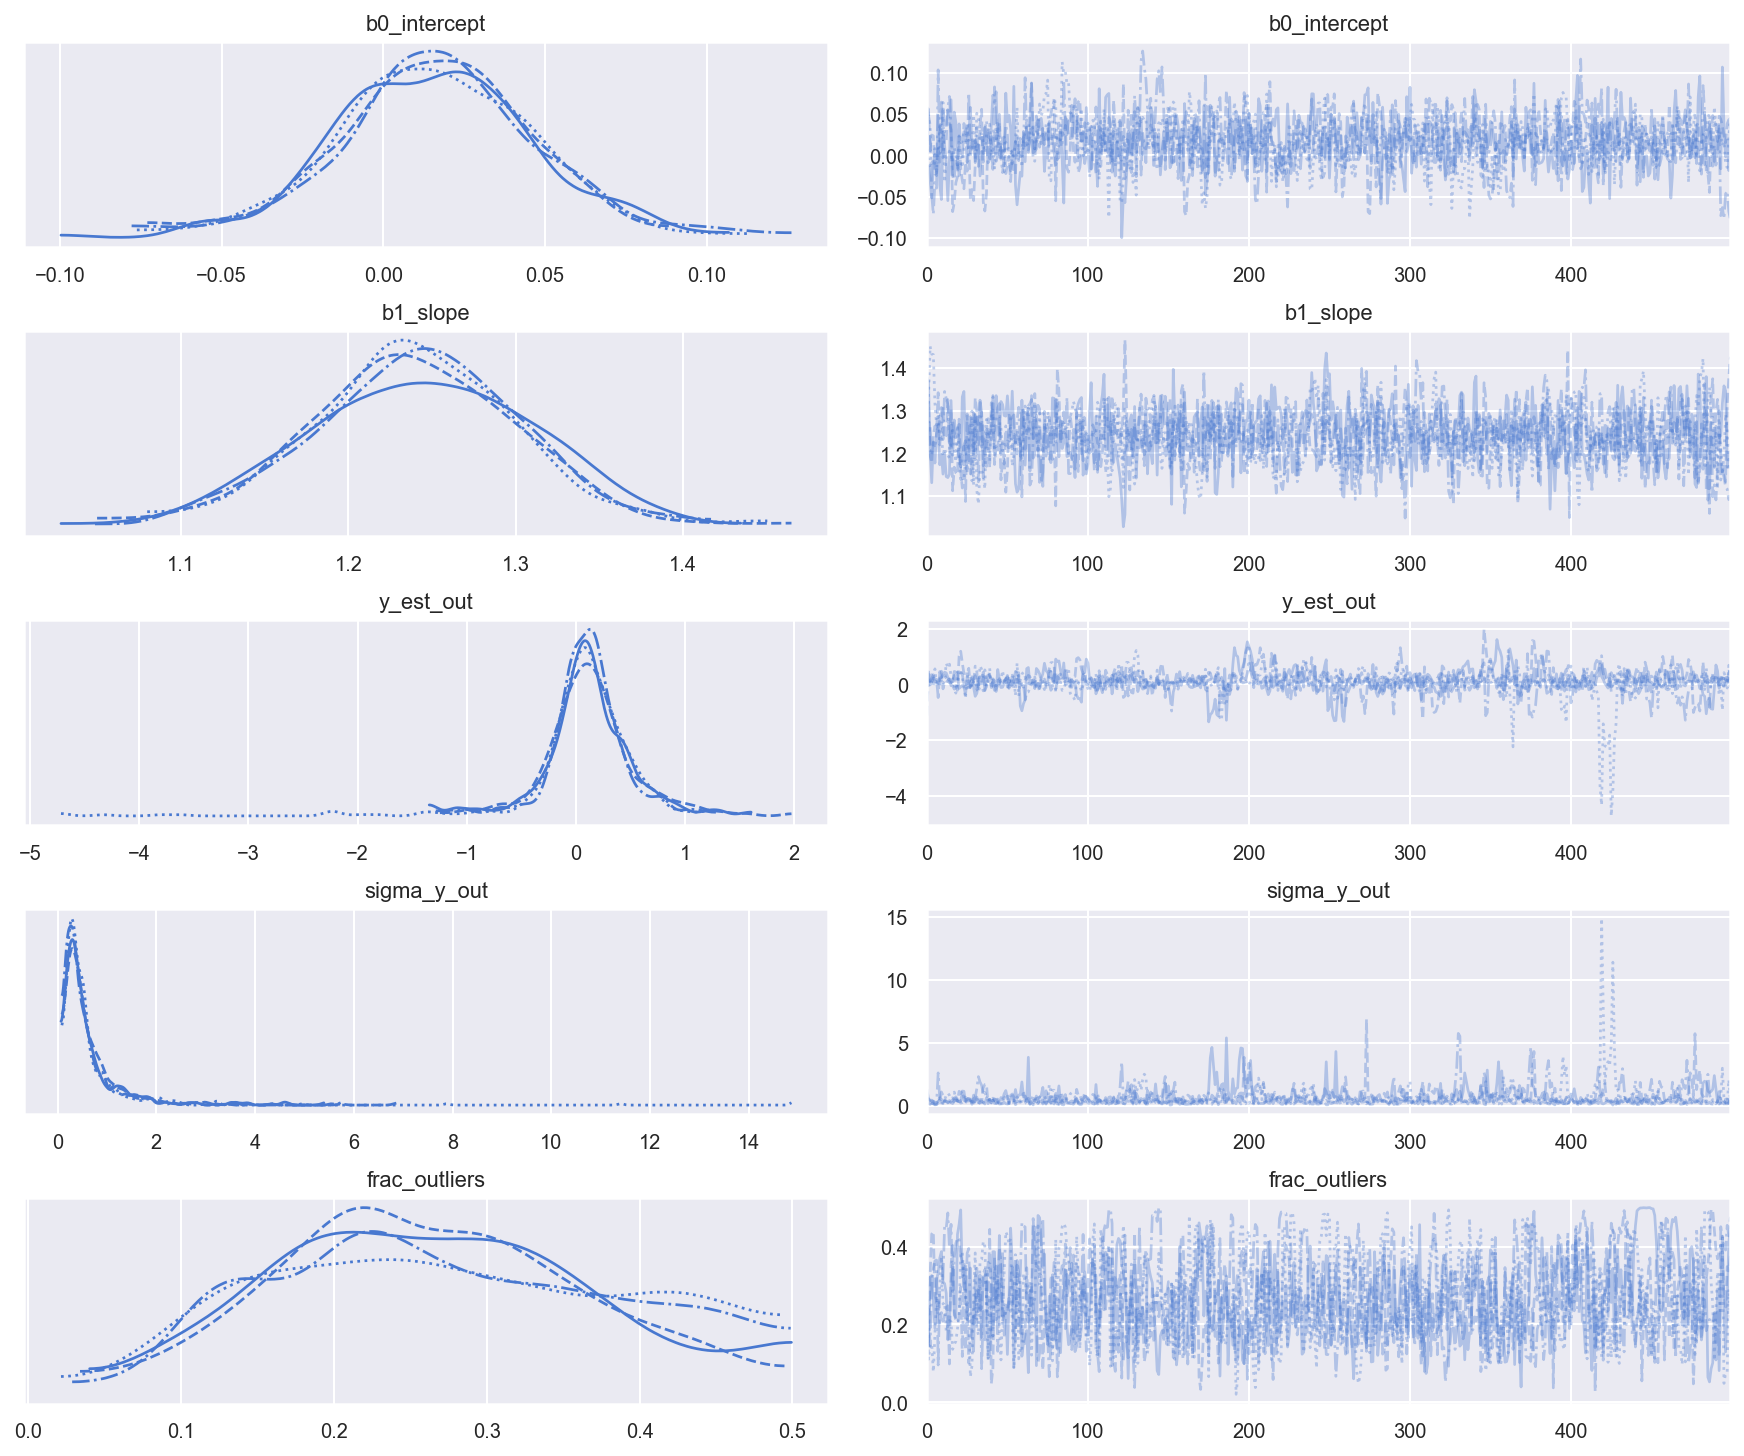

In [19]:
rvs = ["b0_intercept", "b1_slope", "y_est_out", "sigma_y_out", "frac_outliers"]
_ = az.plot_trace(trc_hogg, var_names=rvs)

**Observe:**

+ At the default `target_accept = 0.8` there are lots of divergences, indicating this is not a particularly stable model
+ However, at `target_accept = 0.9` (and increasing `tune` from 5000 to 10000), the traces exhibit fewer divergences and appear slightly better behaved.
+ The traces for the inlier model parameters `b0_intercept` and `b1_slope`, and for outlier model parameter `y_est_out` (the mean) look reasonably converged
+ The traces for outlier model param `y_sigma_out` (the additional pooled variance) occasionally go a bit wild
+ It's intersting that `frac_outliers` is so dispersed: that's quite a flat distribution: suggests that there are a few datapoints where their inlier/outlier status is subjective
+ Indeed as Thomas noted in his v2.0 Notebook, because we're explicitly modeling the latent label (inlier/outlier) as binary choice the sampler could have a problem - rewriting this model into a marginal mixture model would be better.

Simple trace summary inc rhat

In [20]:
az.summary(trc_hogg, var_names=rvs)

/Users/CloudChaoszero/opt/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
b0_intercept   0.016  0.030  -0.039    0.076      0.001    0.001     648.0   
b1_slope       1.241  0.063   1.125    1.363      0.002    0.001    1088.0   
y_est_out      0.097  0.439  -0.555    1.044      0.023    0.017     368.0   
sigma_y_out    0.628  0.780   0.062    1.639      0.040    0.028     384.0   
frac_outliers  0.268  0.106   0.093    0.465      0.004    0.003     601.0   

               ess_sd  ess_bulk  ess_tail  r_hat  
b0_intercept    648.0     663.0     725.0   1.00  
b1_slope       1086.0    1093.0    1109.0   1.00  
y_est_out       354.0     523.0     473.0   1.01  
sigma_y_out     384.0     494.0     705.0   1.01  
frac_outliers   535.0     586.0     641.0   1.01

Plot posterior joint distribution

(This is a particularly useful diagnostic in this case where we see a lot of divergences in the traces: maybe the model specification leads to weird behaviours)


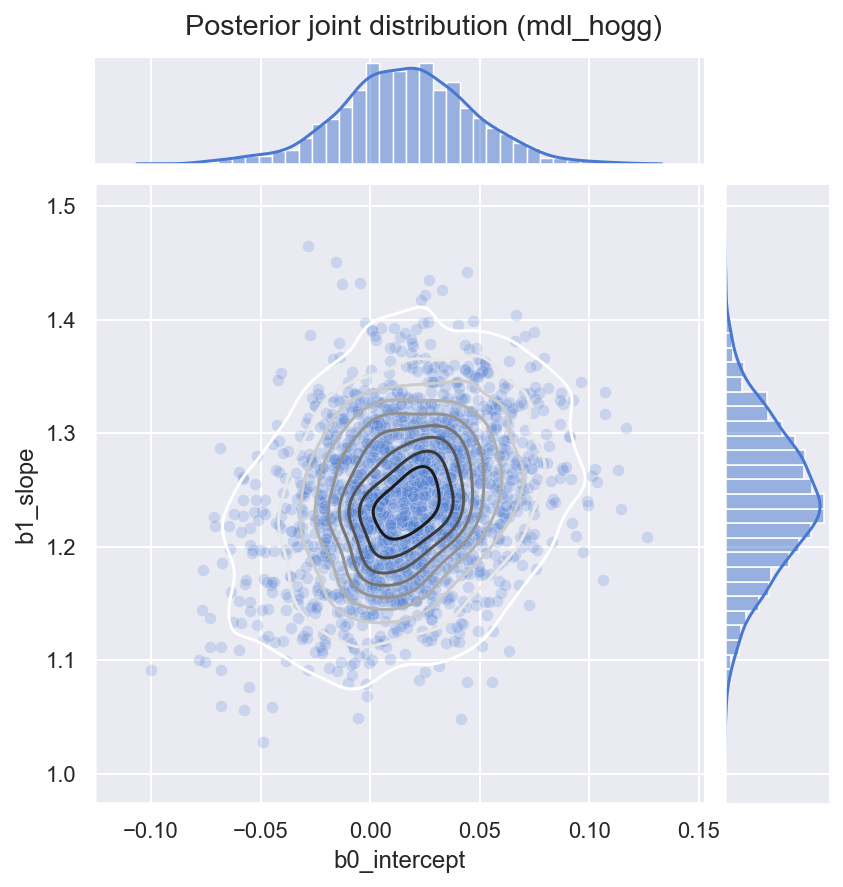

In [21]:
df_trc_hogg = pm.trace_to_dataframe(trc_hogg)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_hogg,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (mdl_hogg)", y=1.02)

#### 5.2.3 View the shift in posterior joint distributions from OLS to StudentT to Hogg

/Users/CloudChaoszero/opt/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/CloudChaoszero/opt/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/CloudChaoszero/opt/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level

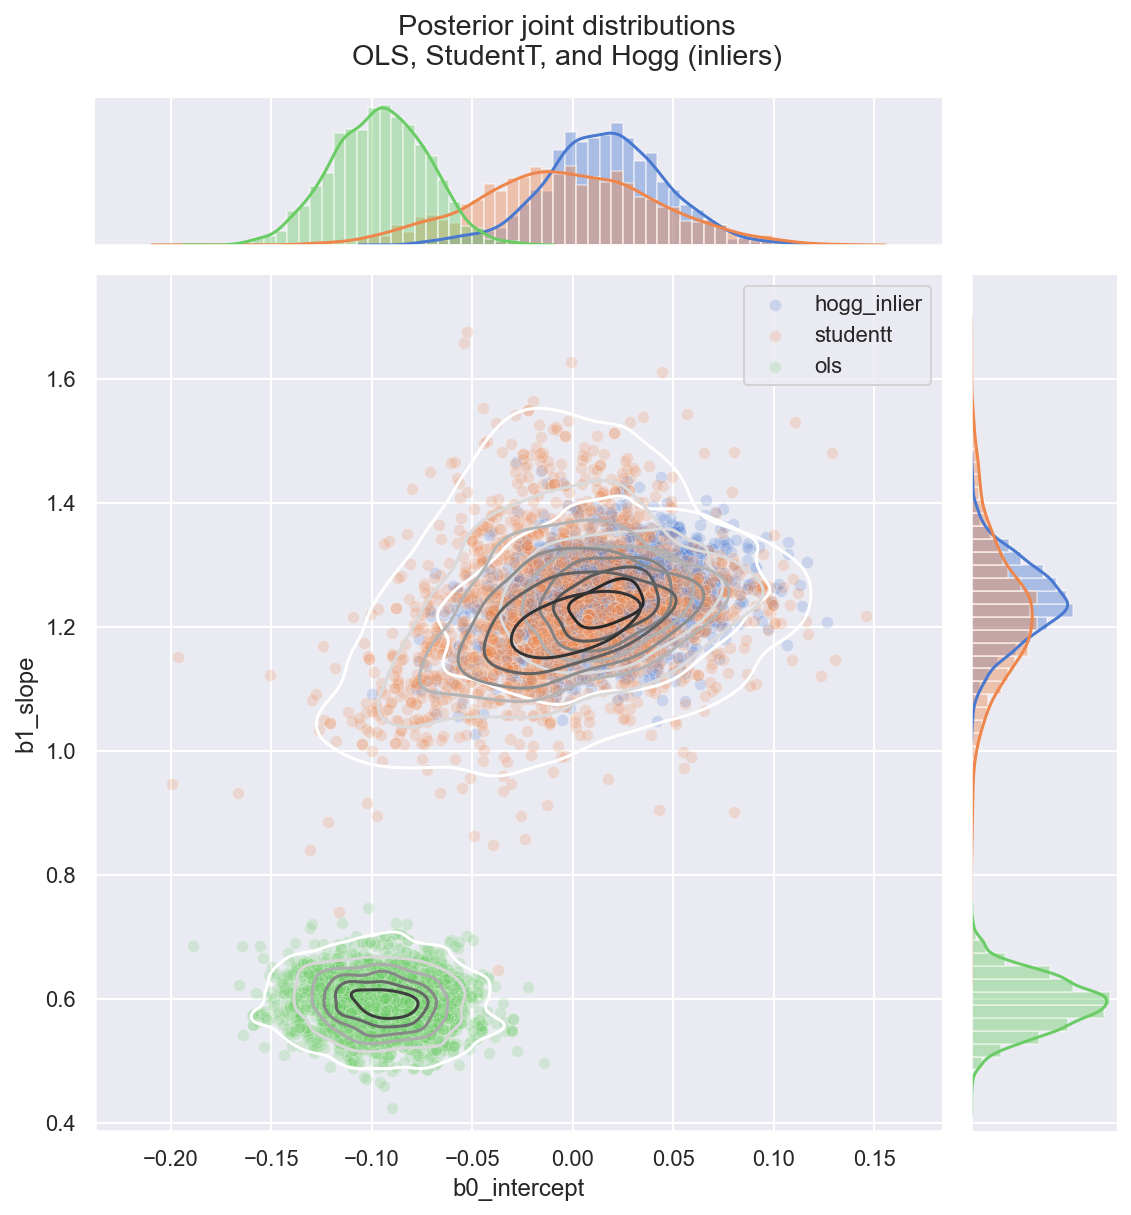

In [22]:
fts = ["b0_intercept", "b1_slope"]
df_trc = pd.concat((df_trc_ols[fts], df_trc_studentt[fts], df_trc_hogg), sort=False)
df_trc["model"] = pd.Categorical(
    np.repeat(["ols", "studentt", "hogg_inlier"], len(df_trc_ols)),
    categories=["hogg_inlier", "studentt", "ols"],
    ordered=True,
)

gd = sns.JointGrid(x="b0_intercept", y="b1_slope", data=df_trc, height=8)
_ = gd.fig.suptitle(
    ("Posterior joint distributions" + "\nOLS, StudentT, and Hogg (inliers)"), y=1.05
)

_, x_bin_edges = np.histogram(df_trc["b0_intercept"], 60)
_, y_bin_edges = np.histogram(df_trc["b1_slope"], 60)

kde_kws = dict(zorder=2, n_levels=7, cmap="gray_r")
dist_kws = dict(kde_kws=dict(cut=1), axlabel=False)

for idx, grp in df_trc.groupby("model"):
    _ = sns.scatterplot(grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, alpha=0.2, label=idx)
    _ = sns.kdeplot(grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, **kde_kws)
    _ = sns.distplot(grp["b0_intercept"], **dist_kws, bins=x_bin_edges, ax=gd.ax_marg_x)
    _ = sns.distplot(grp["b1_slope"], **dist_kws, vertical=True, bins=y_bin_edges, ax=gd.ax_marg_y)
_ = gd.ax_joint.legend()

**Observe:**

+ The `hogg_inlier` and `studentt` models converge to similar ranges for 
`b0_intercept` and `b1_slope`, indicating that the (unshown) `hogg_outlier` 
model might perform a similar job to the fat tails of the `studentt` model: 
allowing greater log probability away from the main linear distribution in the datapoints
+ As expected, (since it's a Normal) the `hogg_inlier` posterior has thinner 
 tails and more probability mass concentrated about the central values
+ The `hogg_inlier` model also appears to have moved farther away from both the 
`ols` and `studentt` models on the `b0_intercept`, suggesting that the outliers 
really distort that particular dimension

### 5.3 Declare Outliers

#### 5.3.1 View ranges for inliers / outlier predictions

At each step of the traces, each datapoint may be either an inlier or outlier. We hope that the datapoints spend an unequal time being one state or the other, so let's take a look at the simple count of states for each of the 20 datapoints.

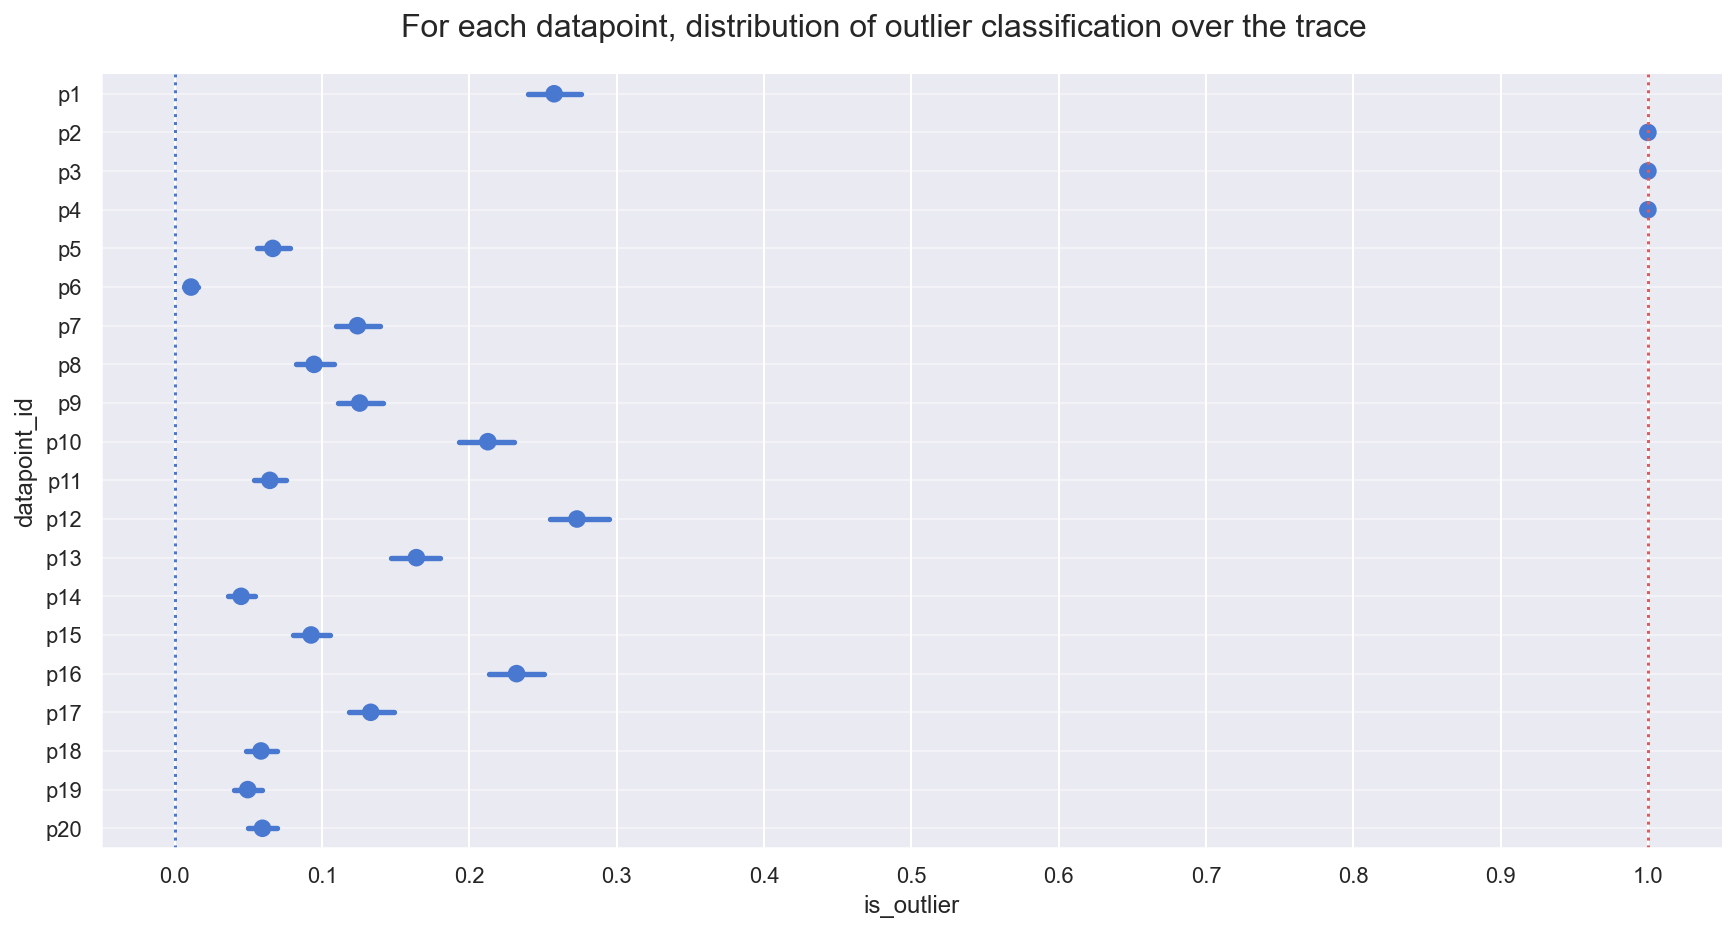

In [23]:
df_outlier_results = pd.DataFrame.from_records(trc_hogg["is_outlier"], columns=dfhoggs.index)
dfm_outlier_results = pd.melt(df_outlier_results, var_name="datapoint_id", value_name="is_outlier")

gd = sns.catplot(
    y="datapoint_id",
    x="is_outlier",
    data=dfm_outlier_results,
    kind="point",
    join=False,
    height=6,
    aspect=2,
)
_ = gd.fig.axes[0].set(xlim=(-0.05, 1.05), xticks=np.arange(0, 1.1, 0.1))
_ = gd.fig.axes[0].axvline(x=0, color="b", linestyle=":")
_ = gd.fig.axes[0].axvline(x=1, color="r", linestyle=":")
_ = gd.fig.axes[0].yaxis.grid(True, linestyle="-", which="major", color="w", alpha=0.4)
_ = gd.fig.suptitle(
    ("For each datapoint, distribution of outlier classification " + "over the trace"),
    y=1.04,
    fontsize=16,
)

**Observe**:

+ The plot above shows the proportion of samples in the traces in which each datapoint is marked as an outlier, expressed as a percentage.
+ 3 points [p2, p3, p4] spend >=95% of their time as outliers
+ Note the mean posterior value of `frac_outliers ~ 0.27`, corresponding to approx 5 or 6 of the 20 datapoints: we might investigate datapoints `[p1, p12, p16]` to see if they lean towards being outliers

The 95% cutoff we choose is subjective and arbitrary, but I prefer it for now, so let's declare these 3 to be outliers and see how it looks compared to Jake Vanderplas' outliers, which were declared in a slightly different way as points with means above 0.68.

#### 5.3.2 Declare outliers

**Note:**
+ I will declare outliers to be datapoints that have value == 1 at the 5-percentile cutoff, i.e. in the percentiles from 5 up to 100, their values are 1. 
+ Try for yourself altering cutoff to larger values, which leads to an objective ranking of outlier-hood.

In [24]:
cutoff = 0.05
dfhoggs["classed_as_outlier"] = np.quantile(trc_hogg["is_outlier"], cutoff, axis=0) == 1
dfhoggs["classed_as_outlier"].value_counts()

False    17
True      3
Name: classed_as_outlier, dtype: int64

Also add flag for points to be investigated. Will use this to annotate final plot

In [25]:
dfhoggs["annotate_for_investigation"] = np.quantile(trc_hogg["is_outlier"], 0.75, axis=0) == 1
dfhoggs["annotate_for_investigation"].value_counts()

False    15
True      5
Name: annotate_for_investigation, dtype: int64

### 5.4 Posterior Prediction Plots for OLS vs StudentT vs Hogg "Signal vs Noise"

<ipython-input-26-ecf4b3037141>:86: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  _ = gd.axes.ravel()[0].annotate(


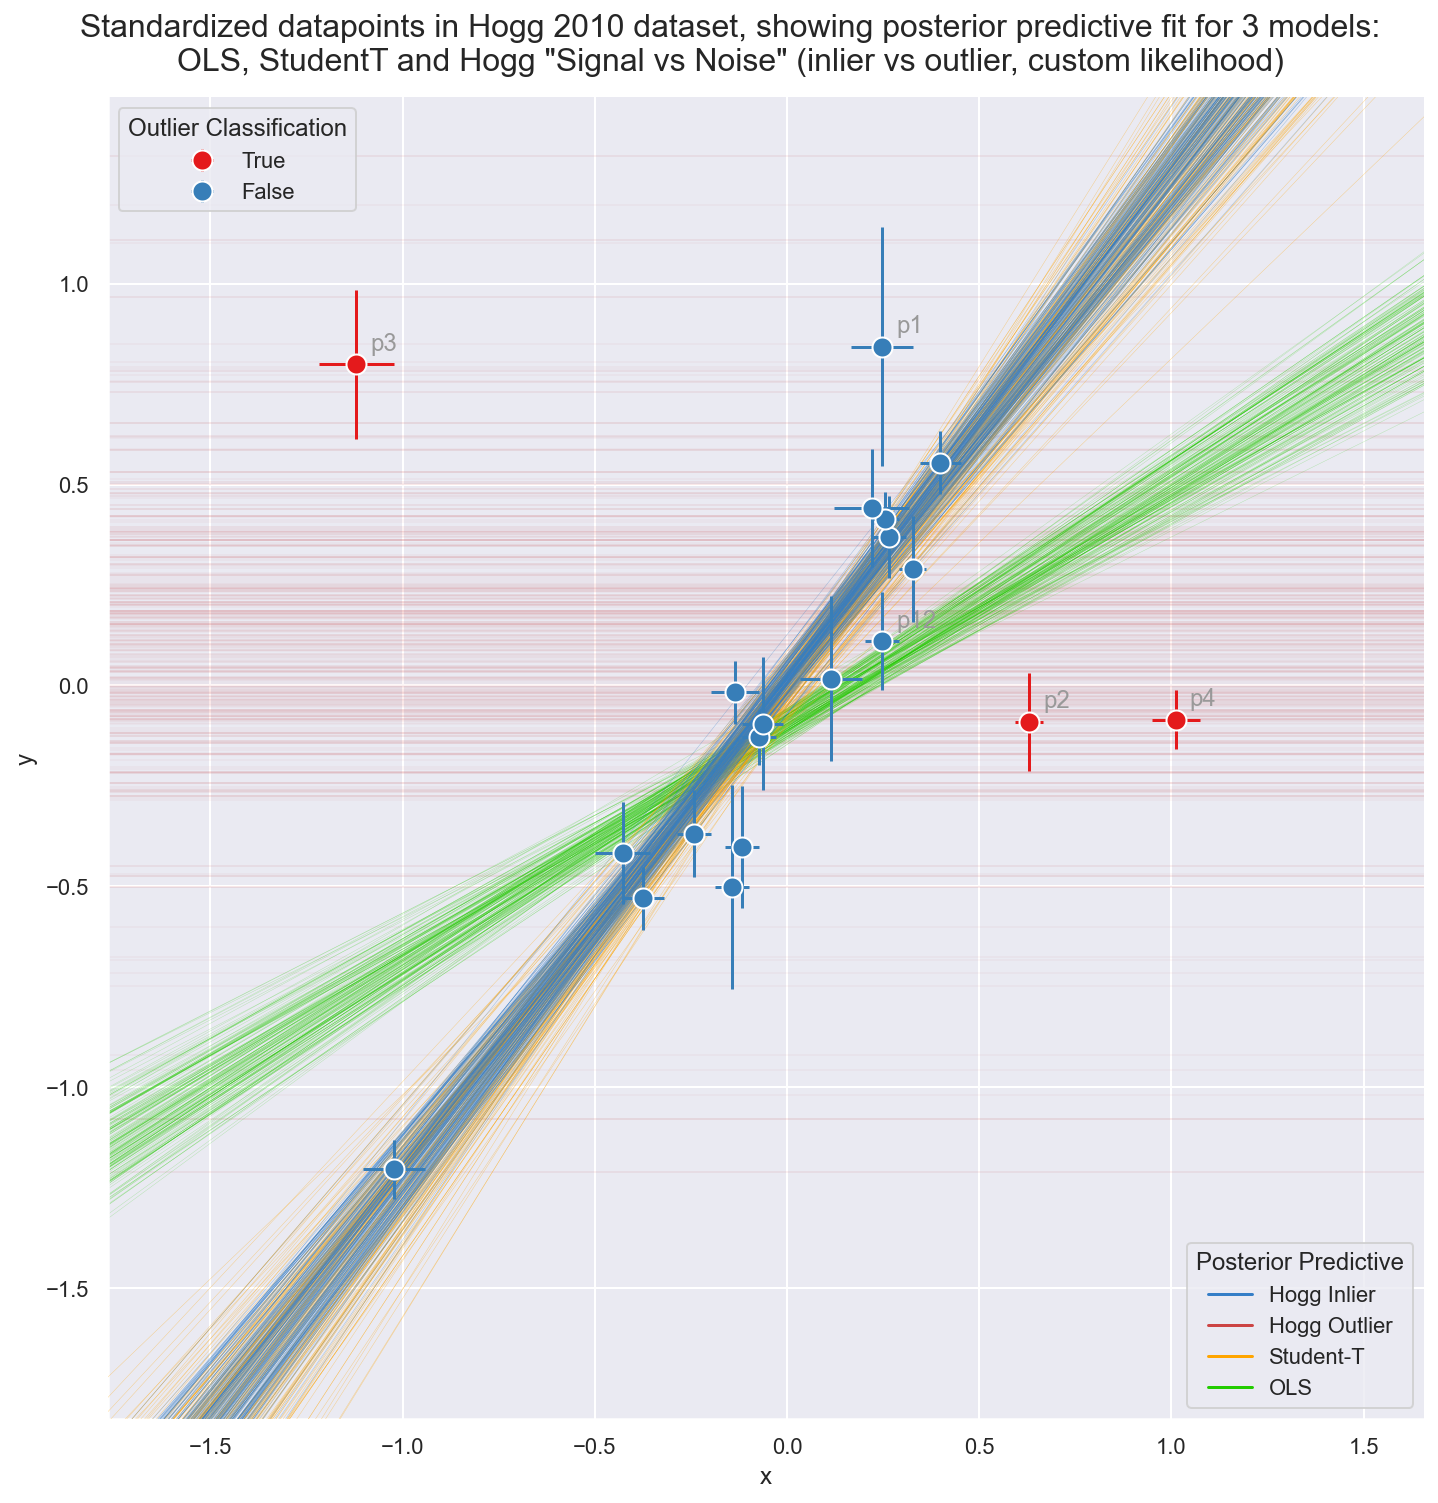

In [26]:
gd = sns.FacetGrid(
    dfhoggs,
    height=10,
    hue="classed_as_outlier",
    hue_order=[True, False],
    palette="Set1",
    legend_out=False,
)

# plot hogg outlier posterior distribution
outlier_mean = lambda x, s: s["y_est_out"] * x ** 0
pm.plot_posterior_predictive_glm(
    trc_hogg,
    lm=outlier_mean,
    eval=np.linspace(-3, 3, 10),
    samples=400,
    color="#CC4444",
    alpha=0.2,
    zorder=1,
)

# plot the 3 model (inlier) posterior distributions
lm = lambda x, s: s["b0_intercept"] + s["b1_slope"] * x

pm.plot_posterior_predictive_glm(
    trc_ols,
    lm=lm,
    eval=np.linspace(-3, 3, 10),
    samples=200,
    color="#22CC00",
    alpha=0.3,
    zorder=2,
)

pm.plot_posterior_predictive_glm(
    trc_studentt,
    lm=lm,
    eval=np.linspace(-3, 3, 10),
    samples=200,
    color="#FFA500",
    alpha=0.5,
    zorder=3,
)

pm.plot_posterior_predictive_glm(
    trc_hogg,
    lm=lm,
    eval=np.linspace(-3, 3, 10),
    samples=200,
    color="#357EC7",
    alpha=0.5,
    zorder=4.0,
)
_ = plt.title(None)

line_legend = plt.legend(
    [
        Line2D([0], [0], color="#357EC7"),
        Line2D([0], [0], color="#CC4444"),
        Line2D([0], [0], color="#FFA500"),
        Line2D([0], [0], color="#22CC00"),
    ],
    ["Hogg Inlier", "Hogg Outlier", "Student-T", "OLS"],
    loc="lower right",
    title="Posterior Predictive",
)
_ = gd.fig.get_axes()[0].add_artist(line_legend)

# plot points
_ = gd.map(
    plt.errorbar,
    "x",
    "y",
    "sigma_y",
    "sigma_x",
    marker="o",
    ls="",
    markeredgecolor="w",
    markersize=10,
    zorder=5,
).add_legend()
_ = gd.ax.legend(loc="upper left", title="Outlier Classification")

# annotate the potential outliers
for idx, r in dfhoggs.loc[dfhoggs["annotate_for_investigation"]].iterrows():
    _ = gd.axes.ravel()[0].annotate(
        s=idx,
        xy=(r["x"], r["y"]),
        xycoords="data",
        xytext=(7, 7),
        textcoords="offset points",
        color="#999999",
        zorder=4,
    )

## create xlims ylims for plotting
x_ptp = np.ptp(dfhoggs["x"].values) / 3.3
y_ptp = np.ptp(dfhoggs["y"].values) / 3.3
xlims = (dfhoggs["x"].min() - x_ptp, dfhoggs["x"].max() + x_ptp)
ylims = (dfhoggs["y"].min() - y_ptp, dfhoggs["y"].max() + y_ptp)
_ = gd.axes.ravel()[0].set(ylim=ylims, xlim=xlims)
_ = gd.fig.suptitle(
    (
        "Standardized datapoints in Hogg 2010 dataset, showing "
        + "posterior predictive fit for 3 models:\nOLS, StudentT and Hogg "
        + '"Signal vs Noise" (inlier vs outlier, custom likelihood)'
    ),
    y=1.04,
    fontsize=16,
)

**Observe**:

##### The posterior preditive fit for:
+ the **OLS model** is shown in **Green** and as expected, it doesn't appear to fit the majority of our datapoints very well, skewed by outliers
+ the **Student-T model** is shown in **Orange** and does appear to fit the 'main axis' of datapoints quite well, ignoring outliers
+ the **Hogg Signal vs Noise model** is shown in two parts:
    + **Blue** for inliers fits the 'main axis' of datapoints well, ignoring outliers
    + **Red** for outliers has a very large variance and has assigned 'outlier' points with more log likelihood than the Blue inlier model 
    
    
##### We see that the **Hogg Signal vs Noise model** also yields specific estimates of _which_ datapoints are outliers:
+ 17 'inlier' datapoints, in **Blue** and
+ 3 'outlier' datapoints shown in **Red**.
+ From a simple visual inspection, the classification seems fair, and agrees with Jake Vanderplas' findings.
+ I've annotated these Red and the most outlying inliers to aid visual investigation
    
    
##### Overall:
+ the **Hogg Signal vs Noise model** behaves as promised, yielding a robust regression estimate and explicit labelling of inliers / outliers, but
+ the **Hogg Signal vs Noise model** is quite complex, and whilst the regression seems robust, the traceplot shoes many divergences, and the model is potentially unstable
+ if you simply want a robust regression without inlier / outlier labelling, the **Student-T model** may be a good compromise, offering a simple model, quick sampling, and a very similar estimate.

---

---

## Notes

Version history:

version | date | author | changes
:--- | :--- | :--- | :---
1.0 | 2015-12-21 | [jonsedar](https://github.com/jonsedar) | Create and publish
2.0 | 2018-07-24 | [twiecki](https://github.com/twiecki) | Restate outlier model using `pm.Normal.dist().logp()` and `pm.Potential()`
2.1 | 2019-11-16 | [jonsedar](https://github.com/jonsedar) | Restate `nu` in StudentT model to be more efficient, drop explicit use of theano shared vars, generally improve plotting / explanations / layout
2.2 | 2020-05-21 | [jonsedar](https://github.com/jonsedar) | Tidyup language, formatting, plots and warnings and rerun with pymc=3.8, arviz=0.7

In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sat Feb 13 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pymc3     : 3.11.0
seaborn   : 0.11.1
scipy     : 1.6.0
matplotlib: None
arviz     : 0.11.0
pandas    : 1.2.1
numpy     : 1.20.0

Watermark: 2.1.0

